# Pre-requirement

```bash
$ pip install numpy
$ pip install matplotlib
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import random
from collections import Counter

# Hyperparameters

- `REJECTS` : determines the proportion of proposals that will be unconditionally rejected during the simulation [%]
- `KS` : represents the number of top proposals to select [integer]
- `BLOCK_INTERVALS` : specifies the maximum time that can simulate during the simulation [ms]
- `PROPOSALS` : represents the total number of proposals [integer]
- `SIMULS` : represents the number of times to run the simulation [interger]

In [2]:
REJECTS = [1] + list(range(1, 101, 5))  # Reject %
KS = [1, 5, 10]  # Best K

BLOCK_INTERVALS = [1000, 2000, 12000]  # ms
PROPOSALS = 20

SIMULS = 10000  # Number of simulation

print("# of Reject:\t\t", len(REJECTS))
print("# of Best-K:\t\t", len(KS))
print("# of Block Interval:\t", len(BLOCK_INTERVALS))
print("# of Proposals:\t\t", PROPOSALS)
print("# of Simulation:\t", SIMULS)

# of Reject:		 21
# of Best-K:		 3
# of Block Interval:	 3
# of Proposals:		 20
# of Simulation:	 10000


In [3]:
# Struct Proposal
class Proposal:
    def __init__(
        self,
        validity: bool,
        bid,
        time_required
    ):
        self.validity = validity
        self.bid = bid
        self.time_required = time_required

# Logic

## `best_bids`

- takes a list of proposals as input
- returns the best **top-$k$** bids in descending order

It filters out any proposals that are invalid or that take longer than a specified `timeout` to simulate.

In [4]:
def best_bids(proposals, top_k, check_validity=True, timeout=None):
    condition_v, condition_t = True, True

    if check_validity:
        condition_v = np.array([p.validity for p in proposals])

    if timeout is not None:
        condition_t = np.array([p.time_required for p in proposals]) <= timeout

    ps = np.array(proposals)[condition_v & condition_t]
    ps = np.array([p.bid for p in ps])
    return ps[ps.argsort()[-min(top_k, len(ps)):][::-1]]

## `pick`

- takes in a list of proposals along with some other parameters
- returns the most profitable proposal according to Optimal Stopping

The function **randomly shuffles** the list of proposals and evaluates them in sequence, rejecting the first $r$ % proposals based on the `reject_percentage` parameter.

The function returns `None` if no valid proposal is found within the time limit specified in the `timeout` parameter or if the `reject_percentage` is too high.

In [5]:
def pick(proposals, reject_percentage, check_validity=True, timeout=None) -> (Proposal):
    # np.random.shuffle(proposals)
    ps = np.random.permutation(proposals)  # shuffle w/ copy

    stop = int(reject_percentage * len(ps) / 100)
    if stop < 1:
        if ps[0].validity:
            return ps[0]
        else:
            return None

    elapsed_time = sum(np.array([p.time_required for p in ps[:stop]]))
    if timeout is not None:
        if elapsed_time > timeout:
            # Need to decrease `reject_percentage`
            return None

    if check_validity:
        pre_validities = np.array([p.validity for p in ps[:stop]])
        if True not in pre_validities:
            return pick(
                proposals=ps[stop:],
                reject_percentage=reject_percentage,
                check_validity=check_validity
            )
        else:
            # Normal case:
            highest_bid_from_rejected = np.max(
                [p.bid for p in (ps[:stop])[np.where(pre_validities)]]
            )
    else:
        # Normal case:
        highest_bid_from_rejected = np.max([p.bid for p in ps[:stop]])

    rest_bid = np.array([p.bid for p in ps[stop:]])

    if timeout is not None:
        remain_time = timeout - elapsed_time
        rest_time_required = np.array([p.time_required for p in ps[stop:]])
        for i, t in enumerate(rest_time_required):
            remain_time -= t
            if remain_time < 0:
                rest_bid = rest_bid[:i]

    if len(rest_bid) == 0:
        # Need to decrease `reject_percentage`
        return None

    # return
    try:
        if check_validity:
            rest_validities = np.array([p.validity for p in ps[stop:stop + len(rest_bid)]])
            best_idx = np.where(
                (rest_bid > highest_bid_from_rejected) & rest_validities
            )
        else:
            best_idx = np.where(
                rest_bid > highest_bid_from_rejected
            )

        if len(best_idx[0]) != 0:
            # Normal case:
            return ps[stop + best_idx[0][0]]
        else:
            # Need to decrease `reject_percentage`
            return None
    except IndexError:
        if check_validity:
            rest_validities = np.array([p.validity for p in ps[stop:stop + len(rest_bid)]])
            if rest_validities[-1]:
                # Normal case:
                return rest_bid[-1]  # pick the last one.
            else:
                return None
        else:
            # Normal case:
            return rest_bid[-1]

# Simulation 1) Top-k Optimal Stopping

- check `validity`
- has `timeout`

## Proposals

Each proposal has:
- `validity`: this proposal is valid or not [True/False]
- `bid`: how much ETH builder want to give to relay [wei]
- `time_required`: how many times this proposal takes to simulate [ms]

In [6]:
# Generate Random Proposals
proposals = [
    Proposal(
        validity=random.random() < 0.9,  # true / false  # 10% malicious builders
        bid=random.randint(0, 30),  # bidding 0~30
        time_required=random.randint(10, 400)  # simulation time(ms) 10~400
    ) for _ in range(PROPOSALS)
]

print("bid:\t\t", [p.bid for p in proposals])
print("validity:\t", [p.validity for p in proposals])
print("time_required:\t", [p.time_required for p in proposals])

bid:		 [26, 15, 28, 16, 2, 17, 9, 14, 27, 26, 26, 23, 23, 16, 27, 4, 4, 15, 13, 20]
validity:	 [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False]
time_required:	 [45, 290, 148, 361, 83, 175, 27, 326, 218, 110, 350, 312, 291, 133, 208, 231, 140, 106, 52, 276]


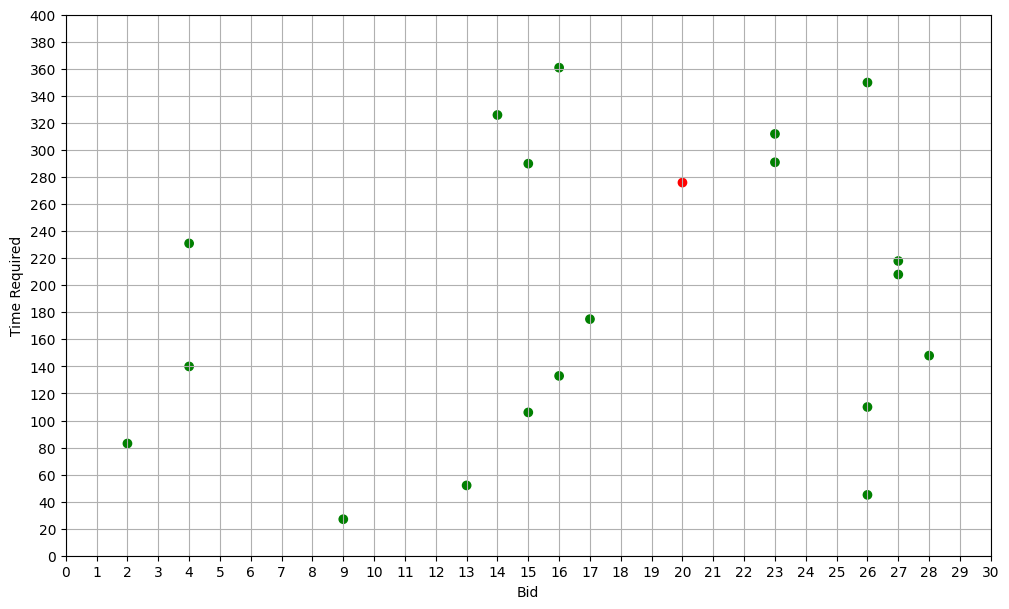

In [7]:
plt.figure(figsize=(10, 6))
plt.xlim(0, 30)
plt.ylim(10, 400)
plt.xticks(np.arange(0, 31, 1))
plt.yticks(np.arange(0, 401, 20))
plt.grid(True)
plt.tight_layout()

plt.scatter(
    [p.bid for p in proposals],
    [p.time_required for p in proposals],
    c=['green' if v else 'red' for v in [p.validity for p in proposals]]
)

plt.xlabel('Bid')
plt.ylabel('Time Required')
# plt.title('Optimal Stopping Proposals')

# plt.show()
plt.savefig(f"./fig/SCONE_proposals.png", dpi=600)

## Check Proposal's Validity

In [8]:
for b in BLOCK_INTERVALS:
    for k in KS:
        answer = best_bids(proposals, top_k=k, timeout=b)
        if len(answer) == 0:
            raise Exception("Invalid Proposals.")
        print(f"answer (k={k:2d}) (b={b:5d}):", answer)

answer (k= 1) (b= 1000): [28]
answer (k= 5) (b= 1000): [28 27 27 26 26]
answer (k=10) (b= 1000): [28 27 27 26 26 26 23 23 17 16]
answer (k= 1) (b= 2000): [28]
answer (k= 5) (b= 2000): [28 27 27 26 26]
answer (k=10) (b= 2000): [28 27 27 26 26 26 23 23 17 16]
answer (k= 1) (b=12000): [28]
answer (k= 5) (b=12000): [28 27 27 26 26]
answer (k=10) (b=12000): [28 27 27 26 26 26 23 23 17 16]


## Run Simulation

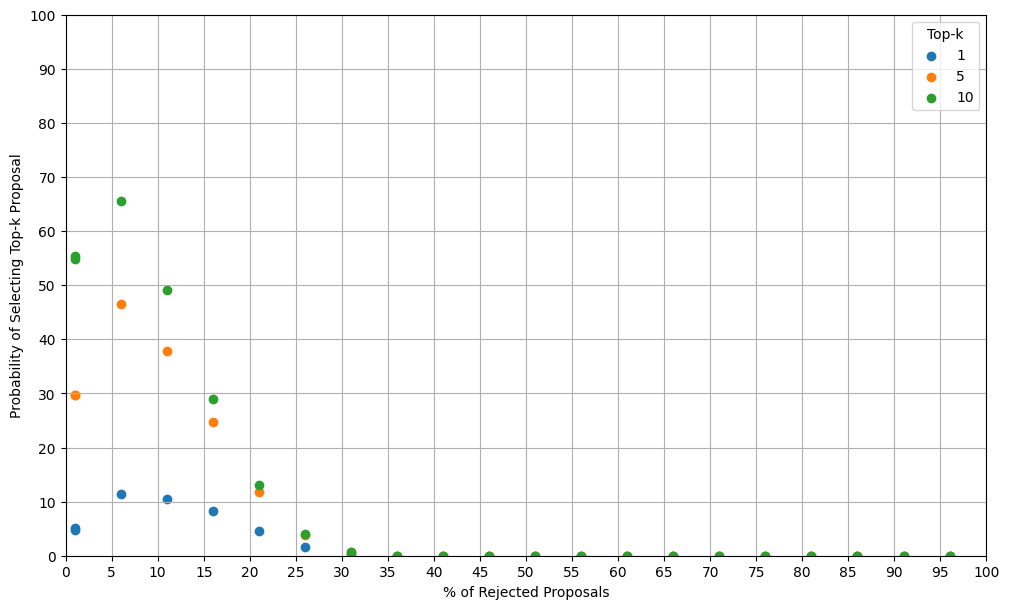

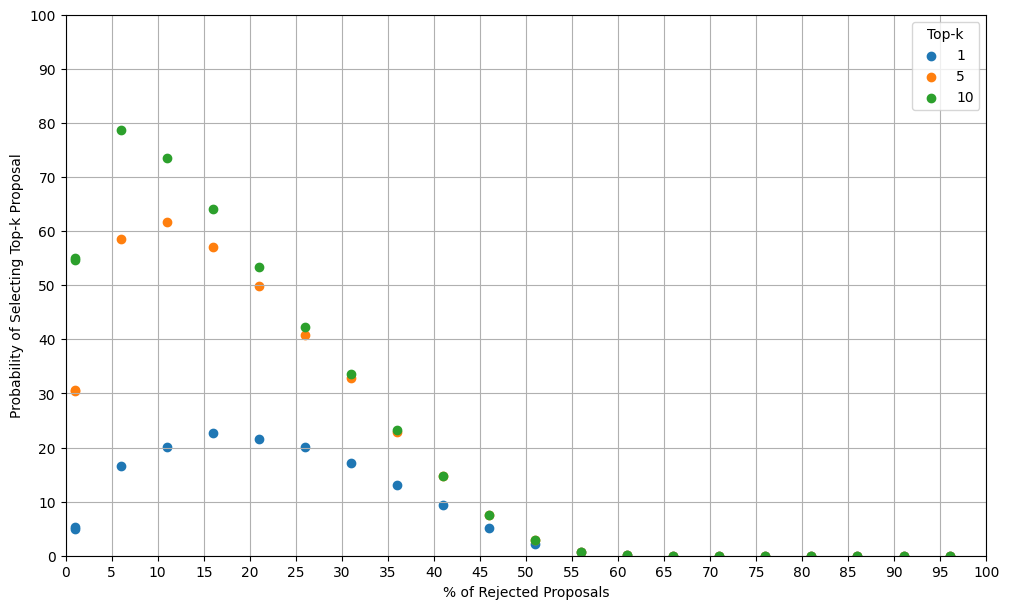

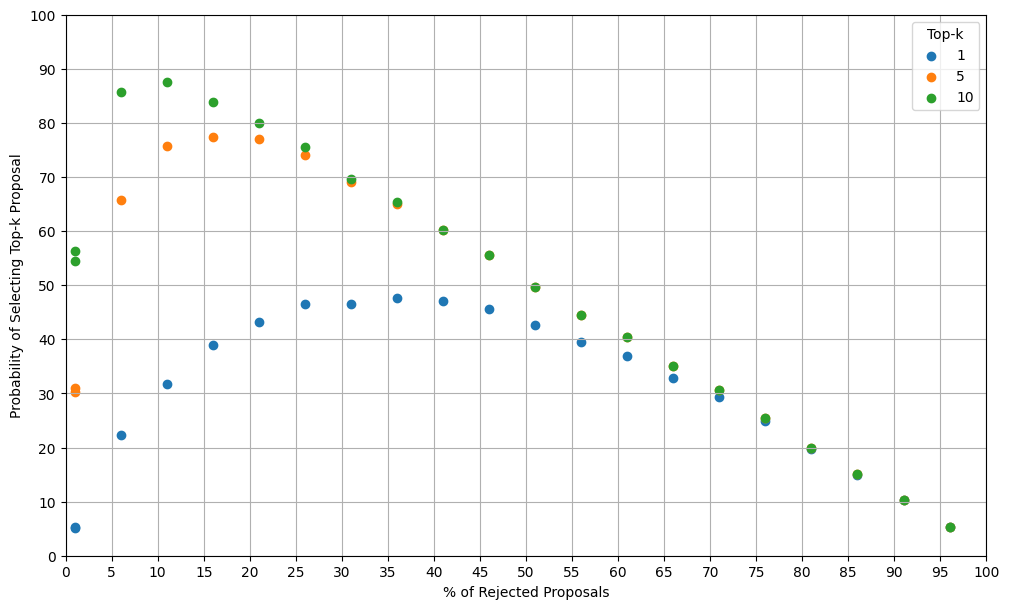

In [9]:
for b in BLOCK_INTERVALS:
    all_res = np.zeros((len(KS), len(REJECTS)))

    for ir, r in enumerate(REJECTS):
        res_ps = [pick(proposals, reject_percentage=r, timeout=b) for _ in range(SIMULS)]
        res_ps = np.array([(p.bid if p is not None else -1) for p in res_ps])
        for ik, k in enumerate(KS):
            answer = best_bids(proposals, top_k=k, timeout=b)

            count_res_ps = Counter(res_ps)
            count_answer = Counter(answer)
            commons = [count_res_ps[e] for e in count_res_ps.keys() & count_answer.keys()]
            all_res[ik][ir] = sum(commons) / SIMULS * 100
            # print(f"b={b}, r={r}, k={k}\t: {len(commons)} / {SIMULS}")

    np.save(f"./data/SCONE_{b}", all_res)

    plt.figure(figsize=(10, 6))
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.xticks(np.arange(0, 101, 5))
    plt.yticks(np.arange(0, 101, 10))
    plt.grid(True)
    plt.tight_layout()

    for ik, k in enumerate(KS):
        plt.scatter(
            REJECTS,
            all_res[ik],
            label=str(k)
        )

    plt.xlabel('% of Rejected Proposals')
    plt.ylabel('Probability of Selecting Top-k Proposal')
    plt.legend(title='Top-k')

    plt.savefig(f"./fig/SCONE_{b}.png", dpi=600)

The simulation results demonstrate that implementing Optimal Stopping at an appropriate percentage [%] is the best strategy for increasing the probability of selecting the top-$k$ proposals, with high efficiency.

# Simulation 2) Ability to pick proposals that have passed

TBD